In [1]:
from mlphon import Syllablizer, G2P, getPhonemelist
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os

## Corpus metadata format
- Alphanumeric speech id
- Path of speech file
- Alphanumeric anonymised speaker id
- Review score
- Transcript in Malayalam script
- Sentence cateogory: `proverb`, `conversation`, `story` and no category indicated by `default`
- Speaker gender: optionally given by user as `female`, `male` or `other` and no response in indicated with `default`
- Speaker gender: optionally given by user or no response in indicated with `default`

In [2]:
df = pd.read_csv("../metadata.tsv", sep="\t", header=0)
df.head()

,speechid,speechpath,speaker_id,review_score,transcript,category,speaker_gender,speaker_age
0,0I2iIh7OSMdWhvb85tMp,audio/63a28877-988f-4f87-a6dd-f0d2b5c24944.wav,oeaNxrE0uxNSfoDpdrCYGBGC7uC3,42,അണ്ണാൻ മൂത്താലും മരം കേറ്റം മറക്കുമോ?,proverb,default,default
1,0Gbc6JQLVd6ah2P5Nz0D,audio/3f6ec7ce-e480-49ba-b53f-29990a3918e7.wav,6FzGR8AJFJSEml6AIs55fEgJmqX2,30,പാണ്ടൻ നായുടെ പല്ലിനു ശൗര്യം പണ്ടേപോല ഫലിയ്‌ക്...,proverb,default,default
2,0PJKVqJsCFeIHKeeIgJ5,audio/1fa2ebd9-e49f-4d73-b4d0-6c8a69a88217.wav,oeaNxrE0uxNSfoDpdrCYGBGC7uC3,29,ചങ്ങലയ്ക്കു ഭ്രാന്തു പിടിച്ചാലോ?,proverb,default,default
3,12T1hc6IeB0OiiiBlSIF,audio/09706980-d14c-49e6-8b98-deeb4bee1a86.wav,Y3uj7LGGFGcrklUpQDW50rwa0hL2,29,അണ്ണാൻ കുഞ്ഞും തന്നാലായത്.,proverb,Male,20-30
4,0WTsBT8bYyLzb9mVDkEb,audio/b1b8f56c-7f2c-437d-972e-38d0c0720a5e.wav,oeaNxrE0uxNSfoDpdrCYGBGC7uC3,26,വിത്താഴം ചെന്നാൽ പത്തായം നിറയും.,proverb,default,default


### Unicode normalization and punctuation removal

In [3]:
sentence_list = df["transcript"].tolist()
normalizesubstring = [['ണ്‍', 'ൺ'], ['ന്‍', 'ൻ'], ['ര്‍', 'ർ'],['ല്‍', 'ൽ'], ['ള്‍', 'ൾ'], ['ക്‍', 'ൿ']] # Conversion to atomic chillu
removepunctuation = [['\u200c', ''], ['\u200d', ''], ['?',''], ['.',''], ['!',''], [',',''], [':','']] # Remove zwj, zwnj, punctuations

In [4]:
normalized_sentencelist=[]
for sentence in sentence_list:
    for sublist in normalizesubstring:
        sentence=sentence.replace(sublist[0], sublist[1])
    for remlist in removepunctuation:
        sentence=sentence.replace(remlist[0], remlist[1])
    normalized_sentencelist.append(sentence)

## Sentence Count: Total and Unique

In [5]:
print('Number of sentences:', len(normalized_sentencelist))
print('Number of unique sentences:', len(set(normalized_sentencelist)))

Number of sentences: 1541
Number of unique sentences: 482


## Word Count: Total and Unique

In [6]:
def getwords(sentencelist): 
    return ' '.join(sentencelist).split() 
word_list = getwords(normalized_sentencelist)
print('Number of words:', len(word_list))
print('Number of unique words:', len(set(word_list)))

Number of words: 5764
Number of unique words: 1400


## Syllable Count: Total and Unique

In [7]:
def getsyllables(wordlist):
    syl = Syllablizer()
    syllables=''
    for word in wordlist:
        syllables= syllables + ' '.join(syl.syllablize(word))+' '
    return(syllables.split())
syllable_list = getsyllables(word_list)
print('Number of syllables:', len(syllable_list))
print('Number of unique syllables:', len(set(syllable_list)))

Number of syllables: 19806
Number of unique syllables: 553


## Phoneme Count: Total and Unique

In [8]:
g2p = G2P()
def getphonemes(syllablelist):
    phoneme_list=''
    for syllable in syllablelist:
        analysis = g2p.analyse(syllable)
        for item in analysis:
            phonemes = getPhonemelist(item[0])
        phoneme_list= phoneme_list+' '+ phonemes
    phoneme_list = phoneme_list.split()
    return(phoneme_list)  
phoneme_list = getphonemes(syllable_list)
print('Number of phonemes:', len(phoneme_list))
print('Number of unique phonemes:', len(set(phoneme_list)))

Number of phonemes: 43620
Number of unique phonemes: 48


## Analysing phonetic richness of the speech corpus

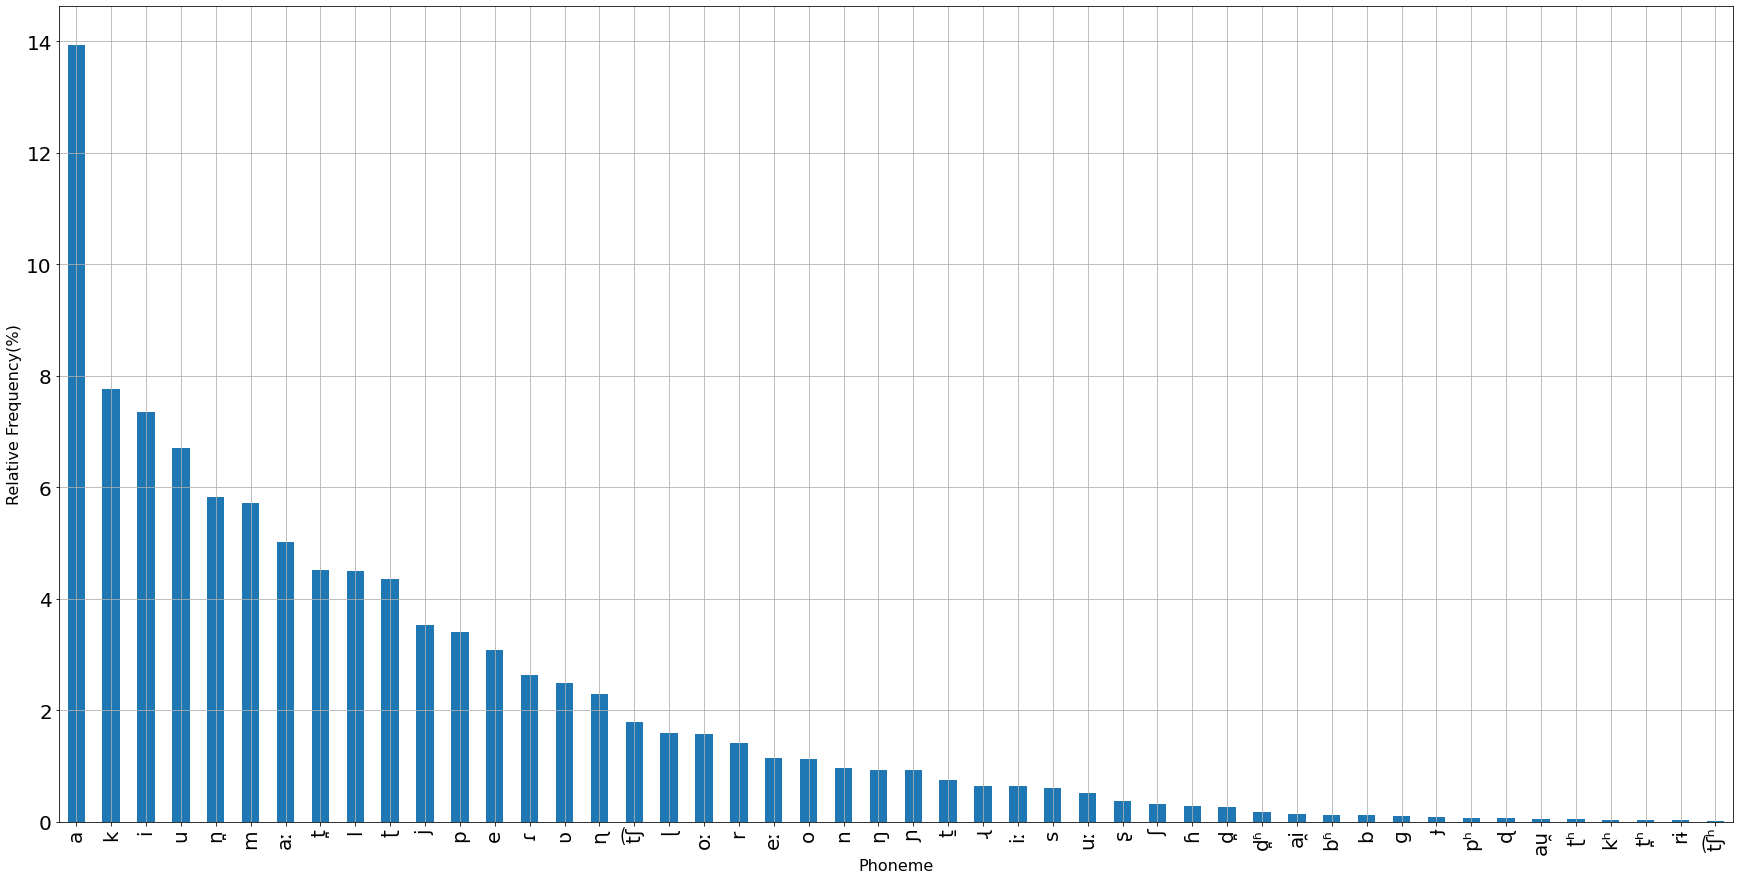

In [9]:
fig = plt.figure(figsize=[30,15])
phoneme_frequency = pd.Series(phoneme_list).value_counts(normalize=True) * 100
phoneme_frequency.plot.bar(fontsize=20)
plt.xlabel("Phoneme",fontsize=16)
plt.ylabel("Relative Frequency(%)", fontsize=16)
plt.grid()

## Sentence category on all recordings

Text(0.5, 1.12, 'Sentence Categories')

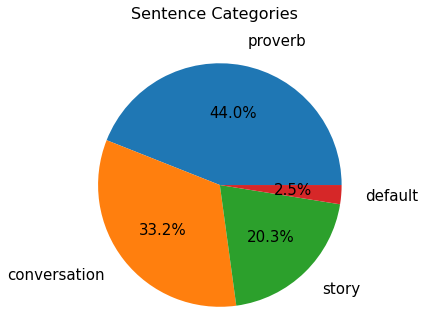

In [10]:
category_count = df.category.value_counts()
category_count.plot(kind='pie', radius=1.4, fontsize=15,labeldistance=1.2, autopct='%1.1f%%')
plt.ylabel('')
plt.suptitle('Sentence Categories', size=16, y=1.12)

## Speaker Demography

default    60
Male       12
Female      3
Name: speaker_gender, dtype: int64
default    60
20-30       7
30-40       7
50-60       1
Name: speaker_age, dtype: int64


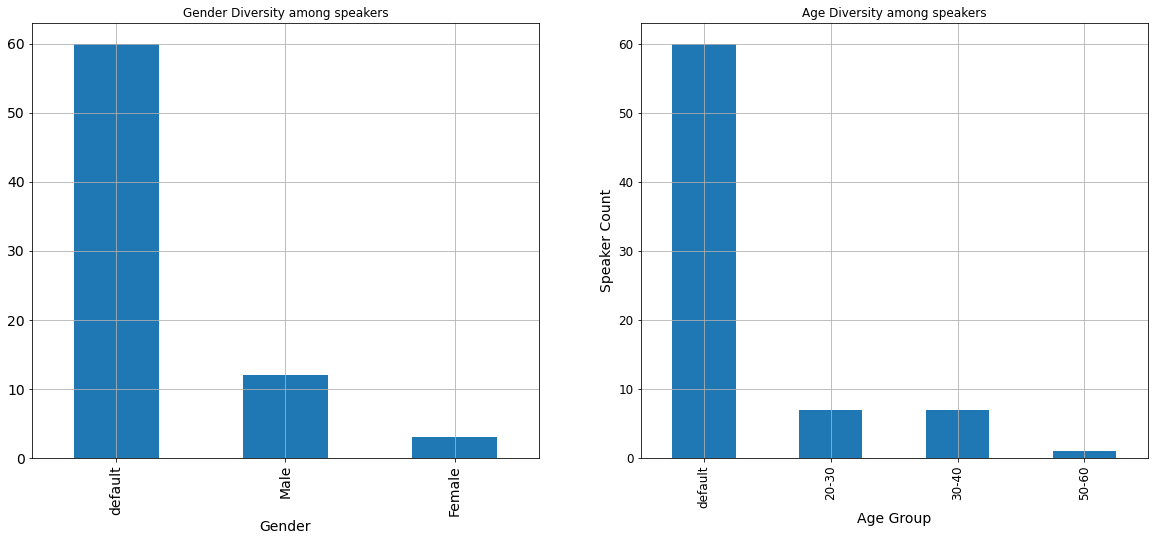

In [11]:
speaker_df = df[["speaker_id", "speaker_gender", "speaker_age"]].drop_duplicates()
gender_count = speaker_df.speaker_gender.value_counts()
print(gender_count)
plt.figure(figsize=[20,8])
plt.subplot(1,2,1)
plt.xlabel('Gender', fontsize=14)  # Add an x-label to the axes.
plt.ylabel('Speaker Count', fontsize=14)  # Add an x-label to the axes.
gender_count.plot(kind='bar',fontsize=14)
plt.ylabel('')
plt.title('Gender Diversity among speakers')
plt.grid()
agegroup_count = speaker_df.speaker_age.value_counts()
print(agegroup_count)
plt.subplot(1,2,2)
agegroup_count.plot(kind='bar',fontsize=12)
plt.xlabel('Age Group', fontsize=14)  # Add an x-label to the axes.
plt.ylabel('Speaker Count', fontsize=14)  # Add an x-label to the axes.
plt.title('Age Diversity among speakers')
plt.grid()

# Number of speech samples recorded by each user

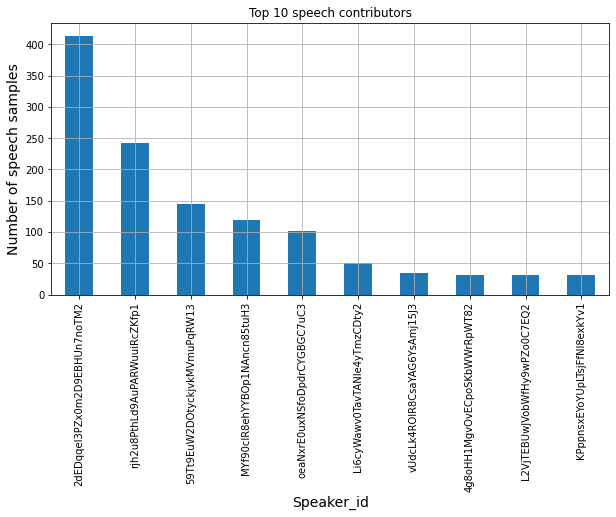

In [12]:
fig = plt.figure(figsize=[10,5])
df.speaker_id.value_counts()[:10].plot(kind='bar')
plt.xlabel("Speaker_id", fontsize=14)
plt.ylabel("Number of speech samples", fontsize=14)
plt.title("Top 10 speech contributors")
plt.grid()

## Speech demography 

Male       678
default    551
Female     312
Name: speaker_gender, dtype: int64


Text(0.5, 1.12, 'Gender Diversity in Speech Corpus')

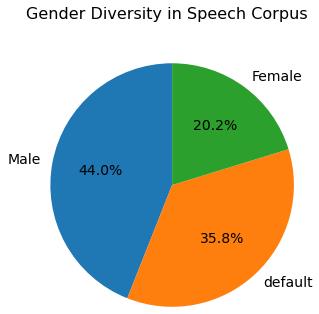

In [13]:
gender_count = df.speaker_gender.value_counts()
print(gender_count)
gender_count.plot(kind='pie',startangle=90, radius=1.4, fontsize=14, autopct='%1.1f%%')
plt.ylabel('')
plt.suptitle('Gender Diversity in Speech Corpus', size=16, y=1.12)

30-40      843
default    551
20-30       96
50-60       51
Name: speaker_age, dtype: int64


Text(0.5, 1.12, 'Age Diversity in Speech Corpus')

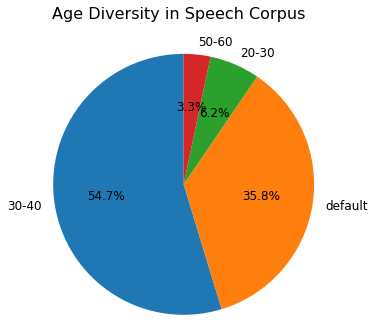

In [14]:
agegroup_count = df.speaker_age.value_counts()
print(agegroup_count)
agegroup_count.plot(kind='pie',startangle=90, radius=1.5, fontsize=12, autopct='%1.1f%%')
plt.ylabel('')
plt.suptitle('Age Diversity in Speech Corpus', size=16, y=1.12)

In [15]:
%%time
sum = 0
filenames = os.listdir('../audio/')
for f in filenames:
    y, sr = librosa.load(os.path.join('../audio/', f))
    sum = sum + librosa.get_duration(y=y, sr=sr)

CPU times: user 4min 49s, sys: 1e+03 ms, total: 4min 50s
Wall time: 4min 56s


# Speech corpus size (duration of recordings)

In [16]:
total_hours = sum//3600
remaining_minutes=(sum%3600)//60
remaining_seconds=sum%60
print("Total duration of corpus in hours is", int(total_hours),"hour",int(remaining_minutes),"minutes", int(remaining_seconds),"seconds")
size = df.shape[0]
print("Average duration of sound clips(s) : ", round(sum/size,2) , "seconds")

Total duration of corpus in hours is 1 hour 38 minutes 16 seconds
Average duration of sound clips(s) :  3.83 seconds
